In [1]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.sparse
import seaborn as sns
import tqdm
import xswap

%matplotlib inline

In [2]:
with tempfile.NamedTemporaryFile() as tf:
    res = requests.get('https://raw.githubusercontent.com/greenelab/xswap/'
                       'testing-data/graphs/GiG_edges_reduced.txt')
    tf.write(res.content)
    edges = xswap.preprocessing.load_processed_edges(tf.name)

edges = list(sorted(set(map(tuple, map(sorted, edges)))))

In [3]:
edges = [edge for edge in edges if edge[1] < 1000]

In [4]:
def edges_to_mat(edges):
    n = max(map(max, edges)) + 1
    return scipy.sparse.coo_matrix((np.ones(len(edges)), (zip(*edges))), shape=(n, n)).toarray()

In [5]:
mat = edges_to_mat(edges)

In [6]:
all(mat[edge] == 1 for edge in edges)

True

In [7]:
def normalize(matrix):
    # Normalize adjacency matrix
    was_sparse = False
    if scipy.sparse.issparse(matrix):
        was_sparse = True
        matrix = matrix.toarray()
    row_sums = (
        matrix
        .sum(axis=1)
        .reshape(matrix.shape[0], 1)
    )
    row_sums[row_sums == 0] = 1
    normalized = np.divide(matrix, row_sums)
    if was_sparse:
        normalized = scipy.sparse.csc_matrix(normalized)
    return normalized


def rwr(normalized_adjacency, start_index, restart_prob, convergence_threshold=1e-6):
    # p(t+1) = (1-r) * W @ p(t) + r * p(0)
    # Setup start position
    p_t = np.zeros((1, normalized_adjacency.shape[0]))
    p_t[0, start_index] = 1
    p_0 = p_t.copy()

    # Iterate RWR until converge
    norm_difference = 1
    while norm_difference > convergence_threshold:
        p_t_1 = (1 - restart_prob) * p_t @ normalized_adjacency + restart_prob * p_0
        norm_difference = np.linalg.norm(p_t_1 - p_t, 1)
        p_t = p_t_1
    return p_t


def all_pairs_rwr(adjacency, restart_prob, convergence_threshold=1e-6):
    normalized_adjacency = normalize(adjacency)

    rwr_matrix = np.zeros(adjacency.shape)

    num_nodes = adjacency.shape[0]
    for seed_index in range(num_nodes):
        rwr_row = rwr(normalized_adjacency, seed_index, restart_prob, 
            convergence_threshold=convergence_threshold)
        rwr_matrix[seed_index, :] = rwr_row
    return rwr_matrix

In [8]:
actual_rwr = all_pairs_rwr(mat, 0.3)

In [9]:
prior = np.zeros_like(mat)
n_greater = np.zeros_like(mat)

n_perms = 50
for i in tqdm.tnrange(n_perms):
    permuted, _ = xswap.permute_edge_list(edges, allow_self_loops=True, allow_antiparallel=True, seed=i)
    permuted_matrix = edges_to_mat(permuted)
    prior += permuted_matrix
    rwr_mat = all_pairs_rwr(permuted_matrix, 0.3)
    n_greater += (rwr_mat * permuted_matrix) > actual_rwr
    
posterior = prior / n_perms * n_greater / n_perms

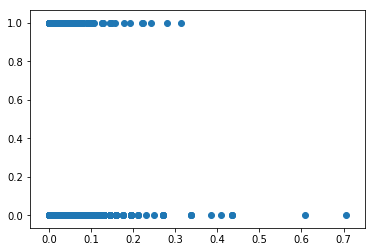

In [10]:
plt.scatter(posterior.flatten(), mat.flatten())

/home/zietzm/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


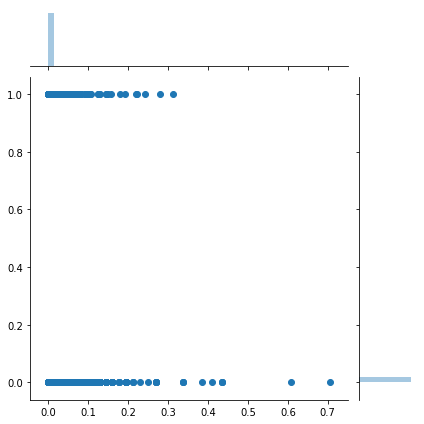

In [11]:
sns.jointplot(posterior.flatten(), mat.flatten())

In [12]:
df = (
    pd.DataFrame()
    .assign(
        edge=mat.flatten(), 
        posterior=posterior.flatten())
)

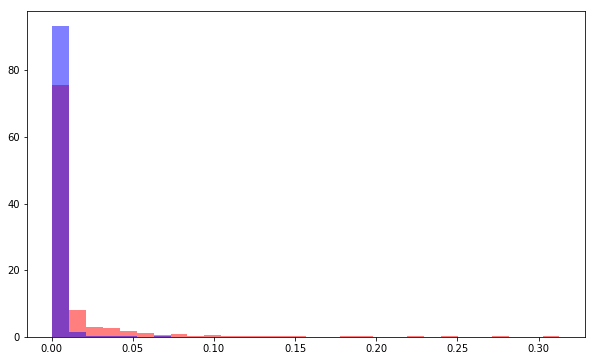

In [34]:
plt.figure(figsize=(10, 6))

n, bins, _ = plt.hist(
    df.query('posterior != 0 and edge == 1')['posterior'], 
    density=True, alpha=0.5, bins=30, color='r')
plt.hist(
    df.query('posterior != 0 and edge == 0')['posterior'], 
    density=True, alpha=0.5, bins=bins, color='b');

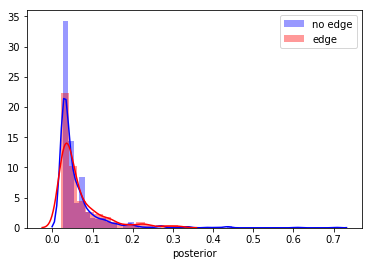

In [45]:
sns.distplot(df.query('posterior > 0.02 and edge == 0')['posterior'], norm_hist=True, color='b', label='no edge')
sns.distplot(df.query('posterior > 0.02 and edge == 1')['posterior'], norm_hist=True, color='r', label='edge')
plt.legend()